# ===============================
# ENSAM – Casablanca BDIOT : TP3
# Régression avec Réseaux de Neurones PyTorch
# Dataset : California Housing Prices
# ===============================

In [ ]:
import pandas as pd
import os

import kagglehub

# Télécharger le dataset
path = kagglehub.dataset_download("camnugent/california-housing-prices")
print("Path to dataset files:", path)

# Charger le fichier CSV
file_path = os.path.join(path, "housing.csv")
df = pd.read_csv(file_path)

# Afficher les 5 premières lignes
print("\nAperçu du dataset :")
print(df.head())

# Optionnel : quelques infos sur la structure
print("\nInfos sur le dataset :")
print(df.info())

print("\nDimensions :", df.shape)

# Supprimer les lignes avec des valeurs manquantes
df = df.dropna()




Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices

Aperçu du dataset :
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        N

Réponses – Exploration du dataset

**• Combien de lignes et de colonnes contient le dataset ?**

Le dataset contient 20 640 lignes et 10 colonnes.
Cela signifie qu’il y a 20 640 maisons observées, chacune décrite par 10 variables.

**• Quelles sont les variables d’entrée ?**

Les variables d’entrée (features) sont :
longitude, latitude, housing_median_age, total_rooms, total_bedrooms,
population, households, median_income, ocean_proximity.


**• Quelle est la variable cible ?**

La variable cible est median_house_value, qui représente la valeur médiane des maisons dans chaque district.

**• Y a-t-il des valeurs manquantes ? Si oui, comment les gérer ?**

Oui , la colonne total_bedrooms contient quelques valeurs manquantes.
On peut les gérer en remplaçant les valeurs manquantes par la moyenne de la colonne :

df["total_bedrooms"].fillna(df["total_bedrooms"].mean(), inplace=True)


**• Quelles sont les unités des variables ? Pourquoi cela peut-il impacter l’apprentissage ?**


longitude, latitude → coordonnées géographiques

housing_median_age → âge médian des maisons (en années)

total_rooms, total_bedrooms, population, households → nombre d’unités

median_income → revenu médian (en dizaines de milliers de dollars)

median_house_value → prix médian des maisons (en dollars)

Les unités sont très différentes (ex : revenus vs coordonnées).
 Cela peut fausser l’apprentissage, car les variables à grande échelle dominent la mise à jour des poids.
 C’est pourquoi on fera une standardisation (normalisation) avant d’entraîner le réseau de neurones.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🔹 Séparer les variables numériques et la variable cible
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Encoder la variable catégorielle 'ocean_proximity'
X = pd.get_dummies(X, drop_first=True)

# 🔹 Division des données
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 🔹 Normalisation des features X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# 🔹 Normalisation de la target y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))  # utile pour l’évaluation finale

print("Forme des ensembles :")
print("Train :", X_train.shape)
print("Validation :", X_val.shape)
print("Test :", X_test.shape)


Forme des ensembles :
Train : (12259, 12)
Validation : (4087, 12)
Test : (4087, 12)



###  **Réponses – Prétraitement des données**

**• Pourquoi standardiser les données est-il crucial pour un réseau de neurones ?**
Standardiser les données (**moyenne = 0, écart-type = 1**) est crucial car :

* Les réseaux de neurones sont sensibles à l’échelle des variables.
* Si certaines features ont des valeurs très grandes et d’autres très petites, les **poids seront déséquilibrés** et l’apprentissage sera plus lent ou instable.
* La standardisation permet un **apprentissage plus rapide et plus stable**.

---

**• Quelle est la différence entre validation set et test set ?**

* **Validation set :** utilisé **pendant l’entraînement** pour ajuster les hyperparamètres du modèle (ex. nombre d’époques, dropout, learning rate).
* **Test set :** utilisé **après l’entraînement** pour évaluer la performance finale sur des données **jamais vues** par le modèle.

> **Important :** le test set doit rester **intouché** pendant l’apprentissage.

---

**• Comment vérifier que la standardisation a bien été appliquée ?**
On peut vérifier que chaque colonne a **moyenne proche de 0** et **écart-type proche de 1** :

Si la moyenne ≈ 0 et l’écart-type ≈ 1 → standardisation OK

---

**• Pourquoi est-il déconseillé d'entraîner sur l'ensemble du dataset sans le diviser ?**

* Si on entraîne sur toutes les données : le modèle **mémorise** les exemples au lieu d’apprendre des **patterns généralisables** → **overfitting**.
* On ne peut pas mesurer la **vraie performance** sur des données jamais vues.
* La division en **train/validation/test** permet de :

  * Entraîner sur le train set
  * Ajuster et stopper l’apprentissage avec le validation set
  * Évaluer la performance réelle avec le test set

---



In [ ]:
import numpy as np

print("Moyenne des features :", np.mean(X_train, axis=0).round(2))
print("Écart-type des features :", np.std(X_train, axis=0).round(2))

Moyenne des features : [-0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0. -0.]
Écart-type des features : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
import torch
import torch.nn as nn

# Définir le modèle de régression
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),  # 1ère couche cachée avec 64 neurones
            nn.ReLU(),                 # activation ReLU
            nn.Dropout(0.3),           # dropout 30% pour éviter overfitting
            nn.Linear(64, 32),         # 2ème couche cachée avec 32 neurones
            nn.ReLU(),
            nn.Dropout(0.2),           # dropout 20%
            nn.Linear(32, 1)           # couche de sortie (1 neurone, pas d'activation)
        )

    def forward(self, x):
        return self.net(x)

# Créer le modèle avec le nombre de features
input_dim = X_train.shape[1]
model = RegressionNN(input_dim)

print(model)


RegressionNN(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


###  **Réponses – Construction du modèle**

**• Pourquoi un réseau de neurones est-il adapté à un problème de régression ?**

* Il peut capturer des **relations non linéaires complexes** entre les variables d’entrée et la variable cible.
* Plus flexible qu’une régression linéaire simple, ce qui permet de mieux modéliser les patterns du dataset.

---

**• À quoi sert la fonction d’activation ReLU ?**

* ReLU = `max(0, x)`
* Rend le réseau **non linéaire**, ce qui permet d’apprendre des patterns complexes.
* Évite le problème du **vanishing gradient**, accélérant et stabilisant l’apprentissage.

---

**• Quel est le rôle de la couche de sortie sans activation ?**

* Pour la régression, on cherche à prédire **une valeur continue**.
* Pas besoin de sigmoid/tanh qui limiteraient la sortie à un intervalle fixe.
* La couche de sortie linéaire permet d’obtenir **n’importe quelle valeur réelle**.

---

**• Qu’est-ce que le Dropout ? En quoi aide-t-il à généraliser ?**

* Le Dropout éteint **aléatoirement certains neurones** pendant l’entraînement.
* Empêche le modèle de **dépendre trop d’un neurone spécifique**, réduisant l’**overfitting**.
* Aide le modèle à **généraliser sur des données jamais vues**.

---

**• Comment choisir le nombre de neurones dans chaque couche ?**

* Il n’existe pas de règle fixe, c’est **souvent expérimental**.
* Trop peu → risque de **sous-apprentissage** (modèle trop simple).
* Trop beaucoup → risque d’**overfitting** et calcul plus lourd.
* On commence souvent avec quelques dizaines ou centaines de neurones et on ajuste selon les performances sur le validation set.

---



In [ ]:
import torch.optim as optim
import copy

# Convertir les datasets en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # déjà 2D
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Fonction de perte et optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
patience = 10
best_loss = float('inf')
counter = 0
best_model = copy.deepcopy(model.state_dict())

#  Boucle d'entraînement
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_model = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping déclenché !")
            break

model.load_state_dict(best_model)
print("Meilleur modèle chargé.")


Epoch 1/200, Train Loss: 0.3274, Val Loss: 0.2717
Epoch 2/200, Train Loss: 0.3238, Val Loss: 0.2709
Epoch 3/200, Train Loss: 0.3276, Val Loss: 0.2703
Epoch 4/200, Train Loss: 0.3274, Val Loss: 0.2699
Epoch 5/200, Train Loss: 0.3240, Val Loss: 0.2695
Epoch 6/200, Train Loss: 0.3189, Val Loss: 0.2690
Epoch 7/200, Train Loss: 0.3232, Val Loss: 0.2685
Epoch 8/200, Train Loss: 0.3225, Val Loss: 0.2679
Epoch 9/200, Train Loss: 0.3219, Val Loss: 0.2674
Epoch 10/200, Train Loss: 0.3217, Val Loss: 0.2669
Epoch 11/200, Train Loss: 0.3196, Val Loss: 0.2664
Epoch 12/200, Train Loss: 0.3230, Val Loss: 0.2661
Epoch 13/200, Train Loss: 0.3216, Val Loss: 0.2658
Epoch 14/200, Train Loss: 0.3206, Val Loss: 0.2656
Epoch 15/200, Train Loss: 0.3200, Val Loss: 0.2654
Epoch 16/200, Train Loss: 0.3196, Val Loss: 0.2651
Epoch 17/200, Train Loss: 0.3194, Val Loss: 0.2648
Epoch 18/200, Train Loss: 0.3193, Val Loss: 0.2645
Epoch 19/200, Train Loss: 0.3169, Val Loss: 0.2640
Epoch 20/200, Train Loss: 0.3163, Val Lo

• **Pourquoi MSE est-il utilisé comme fonction de perte pour la régression ?**  
  MSE (**Mean Squared Error**) pénalise fortement les grandes erreurs et est différentiable, ce qui facilite l’optimisation par gradient.

• **Quelle est la différence entre MSE et MAE ?**  
  - **MSE** : moyenne des carrés des erreurs, sensible aux outliers.  
  - **MAE** : moyenne des valeurs absolues des erreurs, moins sensible aux outliers.

• **Quels sont les avantages d’EarlyStopping ?**  
  - Empêche le surapprentissage (**overfitting**).  
  - Réduit le temps d’entraînement en stoppant tôt si le modèle ne s’améliore plus.

• **Pourquoi est-il utile de sauvegarder le meilleur modèle ?**  
  - Permet de conserver le modèle avec la meilleure performance sur l’ensemble de validation.  
  - On peut restaurer ce modèle même après plusieurs epochs où la performance se dégrade.

• **Comment ajuster le learning rate et quand faut-il le faire ?**  
  - Réduire le learning rate si le loss stagne ou oscille trop.  
  - Ajuster via un **scheduler** ou essais empiriques pour stabiliser l’entraînement.


**MSE**: 0.23
**RMSE**: 0.48
**MAE**: 0.34


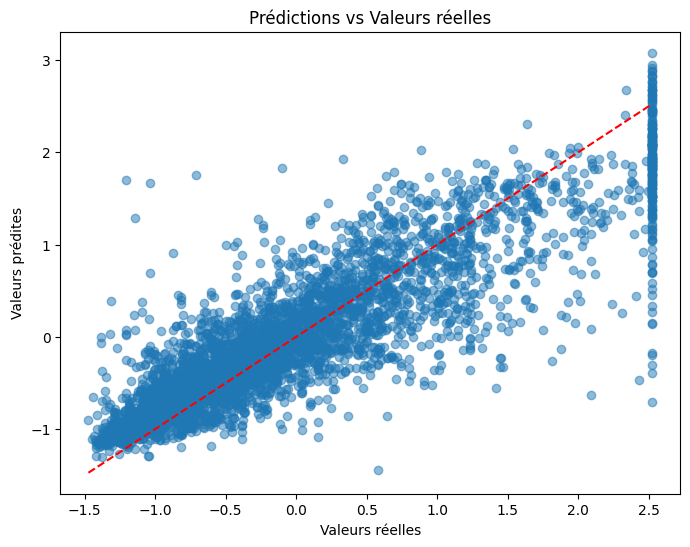

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Convert X_test en tenseur
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Mettre le modèle en mode évaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Calculer les métriques
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"**MSE**: {mse:.2f}")
print(f"**RMSE**: {rmse:.2f}")
print(f"**MAE**: {mae:.2f}")

# Tracer valeurs prédites vs réelles
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # ligne y=x
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Prédictions vs Valeurs réelles")
plt.show()

---

**• Quels indicateurs permettent de mesurer la performance d’un modèle de régression ?**

* **MSE (Mean Squared Error)** : moyenne des carrés des erreurs, pénalise fortement les grandes erreurs.
* **MAE (Mean Absolute Error)** : moyenne des valeurs absolues des erreurs, moins sensible aux valeurs extrêmes.
* **RMSE (Root MSE)** : racine carrée de MSE, garde l’unité originale.
* **R² (Coefficient de détermination)** : proportion de la variance expliquée par le modèle.

---

**• Que signifie un MSE élevé ? Et un MAE élevé ?**

* **MSE élevé** : grandes erreurs fréquentes, modèle peu précis et sensible aux outliers.
* **MAE élevé** : erreurs importantes en moyenne, le modèle ne prédit pas bien les valeurs centrales.

---

**• Comment interpréter un graphique de prédictions vs valeurs réelles ?**

* Les points doivent être proches de la **diagonale y = x**.
* Écart important → erreurs élevées.
* Tendances non diagonales → biais ou sous-apprentissage du modèle.

---

**• Que pourrait-on faire si le modèle sous-performe sur les données de test ?**

* Vérifier le **prétraitement** (normalisation, encodage).
* Ajouter plus de **données** ou **features** pertinentes.
* Modifier l’**architecture du modèle** ou ajuster les **hyperparamètres**.
* Essayer des techniques de **régularisation** pour éviter overfitting ou underfitting.

---

**• Pourquoi est-il important de tester sur des données jamais vues par le modèle ?**

* Pour évaluer la **généralisation réelle**.
* Mesurer la performance sur des cas **réels** et éviter de se baser uniquement sur le train/validation.
* Détecter un **overfitting** si le modèle performe bien sur le train mais mal sur le test.

---
